# Time Series Forecasting

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Reading the data set

In [58]:
ds = pd.read_csv("Data set in csv format/data") #read the csv data file
sales = np.array(ds["Sales"]) # Extract the sales column from the data
TP = np.array(range(1,25))  #Time period column from the data

sales_train_y= sales[:24]  #first 2 years are used as Training data
n = len(sales_train_y)

sales_test_y= sales[24:] #3rd year is used as the test data

### 1 . Cleansing / Removing outliers

__Remove Outliers Using Normal Distribution and S.D__

We needed to remove these outlier values because they make the scales on the graph unrealistic. The challenge is that the number of these outlier values was never fixed. Sometimes one would get all valid values and sometimes these erroneous readings would cover as much as 10% of the data points.

One approach is to remove the outlier points by supressing any points that were above (Mean + NxSD) and any points below (Mean - NxSD) before plotting the frequencies , where N = 1,2,...6

Here the points above (Mean + NxSD) are marked as (Mean + NxSD) and the points below (Mean - NxSD) are marked as (Mean - NxSD).
Rest of the points lie within those ranges of sigma.

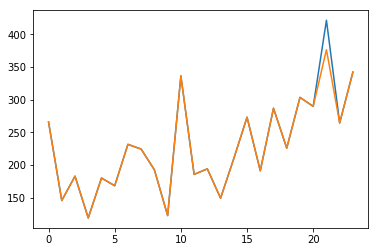

In [59]:
'''
mean --> Mean of the training data
std  --> Standard Deviation of the training data
 N   --> N sigma parameter
'''
mean = np.mean(sales_train_y , axis =0)
std  = np.std(sales_train_y, axis = 0)
list1 = sales_train_y.copy()
sales_clean = np.zeros(len(sales_train_y))
N = 2
for x in range(len(list1)):
    if list1[x]  < ( mean - N*std):
        sales_clean[x] = mean - N*std
    elif list1[x] > ( mean + N*std ):
        sales_clean[x] = mean + N*std
    else:
        sales_clean[x] = list1[x]

# for x in range(len(list1)):
#     print(list1[x],"  ",list2[x],"  yes" if list1[x] == list2[x] else "  No")
        
plt.plot(list1)
plt.plot(sales_clean)
plt.show()

### 2. Smoothen the data using the Moving average method
__Smoothening of data removes the SEASONAL component and the IRREGULAR component from the data__

In Moving Average Smoothing, each observation is assigned an equal weight, and each observation is forecasted by using the average of the previous observation(s). Using the time series X1, X2, X3, ....., Xt, this smoothing technique predicts Xt+k as follows :

St = Average (xt-k+1, xt-k+2, ....., xt), t= k, k+1, k+2, ...N

where, k is the smoothing parameter.

####  2.1 Generating the baseline

In [60]:
''' 
MA --> Moving Average
'''
MA = np.zeros(n)  #initializing the current Moving Avg array to zero
x=0
for i in range(2,n-1):  #
#     print(sales_clean[x:x+4])
    MA[i] = sum(sales_clean[x:x+4]/4)
    x+=1
MA
# plt.plot(MA)

# plt.show()

array([   0.        ,    0.        ,  178.575     ,  157.15      ,
        162.8       ,  174.975     ,  201.275     ,  204.4       ,
        193.        ,  219.175     ,  209.525     ,  209.9       ,
        216.55      ,  184.95      ,  206.8       ,  206.075     ,
        240.45      ,  244.425     ,  252.        ,  276.625     ,
        299.01570604,  308.64070604,  318.31570604,    0.        ])

__Centered moving average__

The idea behind Centered Moving Average approach is getting a moving average that’s centered on an existing midpoint, when there’s an even number of seasons, is to pull that midpoint forward by half a season. 
You calculate a moving average that would be centered at, say, the third point in time if five seasons instead of four constituted one full turn of the calendar.
That’s done by taking two consecutive moving averages and averaging them.

This method generates a __Baseline__  (blue line below) for the data
A baseline is a method that uses heuristics, simple summary statistics, randomness, or machine learning to create predictions for a dataset. You can use these predictions to measure the baseline's performance (e.g., accuracy)-- this metric will then become what you compare any other machine learning algorithm against.

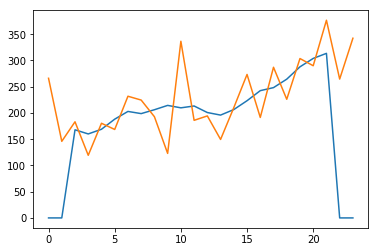

[   0.            0.          167.8625      159.975       168.8875      188.125
  202.8375      198.7         206.0875      214.35        209.7125      213.225
  200.75        195.875       206.4375      223.2625      242.4375
  248.2125      264.3125      287.82035302  303.82820604  313.47820604
    0.            0.        ]


In [61]:
'''
CMA --> Centered Moving Average
MA  --> Moving Average
'''
CMA = np.zeros(n)
x =2
for i in range(2,len(MA)-2):
    CMA[i] = sum(MA[x:x+2])/2
    x+=1

plt.plot(CMA)
plt.plot(sales_clean)
plt.show()
print(CMA)

#Baseline achieved

###  3.Forecasting
####  3.1 Extracting Seasonality and Irregularity from the data
We extract the seasonal and irregular component from the difference btwn the original data and the smoothened data.


The classical multiplicative model says that the time series (Y) is the product of Seasonal component(S), Irregular component(I) and the Trend (T) component.

__Y = S x I x T__


In [62]:
''' 
To obtain SxI we use the following formula
S x I = Y / CMA

( S x I ) --> season_ireg
    Y     --> sales_clean
    CMA   --> CMA
'''
season_ireg = np.zeros(n)
for i in range(n-1):
    if CMA[i]!=0: season_ireg[i] = sales_clean[i] / CMA[i]  
season_ireg

array([ 0.        ,  0.        ,  1.0907737 ,  0.74574152,  1.06757457,
        0.89568106,  1.14278671,  1.12984399,  0.93552496,  0.57336132,
        1.6045777 ,  0.87184899,  0.96787049,  0.76324186,  1.01774145,
        1.22411959,  0.78948183,  1.15626731,  0.85504847,  1.05482464,
        0.95415763,  1.20124084,  0.        ,  0.        ])

#### 3.1.1 Seasonality
Seasonal component is extracted by averaging all the corresponding available values for the months in Seasonal Irregularity data.

For ex

| months | SI   |
|--------|------|
|   1    | 1.10 |
|   2    | 1.13 |
|   3    | 0.99 |
|   4    | 0.82 |
|   1    | 0.97 |
|   2    | 1.18 |
|   3    | 1.11 |

Seasonality of month 1 = avg (1.10 , 0.97)

Seasonality of month 2 = avg (1.13 , 1.18)

Seasonality of month 3 = avg (0.99 , 1.11)

and so on...



In [63]:
seasonality = np.zeros(n)
for i in range(12):
    count=0
    if season_ireg[i] !=0 : count+=1
    if season_ireg[i+12] !=0 : count+=1
    x =  ( season_ireg[i] + season_ireg[i+12]) / count
    seasonality[i],seasonality[i+12]= x,x
seasonality

array([ 0.96787049,  0.76324186,  1.05425757,  0.98493056,  0.9285282 ,
        1.02597419,  0.99891759,  1.09233431,  0.94484129,  0.88730108,
        1.6045777 ,  0.87184899,  0.96787049,  0.76324186,  1.05425757,
        0.98493056,  0.9285282 ,  1.02597419,  0.99891759,  1.09233431,
        0.94484129,  0.88730108,  1.6045777 ,  0.87184899])

#### 3.1.2 De-Seasonlize the data
Removing of the Seasonality from the data
This is done by dividing the Original data by Seasonality.

__De-seasonlize = Y / S__

In [64]:
'''
De_season --> calculated Deseasonlized data is stored here
'''
De_season = np.zeros(n)
for i in range(n):
    De_season[i]=sales_clean[i] / seasonality[i]
De_season

array([ 274.83015955,  191.15827759,  173.67672256,  121.12529077,
        194.17827113,  164.23415141,  232.05117355,  205.52316029,
        204.05543391,  138.50991765,  209.7125    ,  213.225     ,
        200.75      ,  195.875     ,  199.28716226,  277.48149176,
        206.13267385,  279.73413326,  226.24488879,  277.93688848,
        306.82401604,  424.39125927,  164.84088039,  392.61386498])

#### 3.2 Generate the Trend using a linear regression model
To obtain Trend component run a simple linear regression model with 

Y-variable as the De-seasonalized data 

and 

X-variable as the time period

In [65]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression() #The linear regression model
LR.fit(TP[:,np.newaxis] , De_season[:,np.newaxis]) #fits the x and y axis on the model
print(LR.intercept_) #Intercept of the regression line
print(LR.coef_)   #Slope of the regression line

[ 155.09308987]
[[ 5.8405272]]


#### 3.2.2 Trend
The generated line via the Linear regression model is the trend component of the data.


In [66]:
# Prediction applied
TP2 = np.array(range(1,37))
Trend = LR.predict(TP2[:,np.newaxis])
Trend

array([[ 160.93361708],
       [ 166.77414428],
       [ 172.61467148],
       [ 178.45519868],
       [ 184.29572588],
       [ 190.13625308],
       [ 195.97678029],
       [ 201.81730749],
       [ 207.65783469],
       [ 213.49836189],
       [ 219.33888909],
       [ 225.17941629],
       [ 231.0199435 ],
       [ 236.8604707 ],
       [ 242.7009979 ],
       [ 248.5415251 ],
       [ 254.3820523 ],
       [ 260.2225795 ],
       [ 266.06310671],
       [ 271.90363391],
       [ 277.74416111],
       [ 283.58468831],
       [ 289.42521551],
       [ 295.26574271],
       [ 301.10626992],
       [ 306.94679712],
       [ 312.78732432],
       [ 318.62785152],
       [ 324.46837872],
       [ 330.30890592],
       [ 336.14943313],
       [ 341.98996033],
       [ 347.83048753],
       [ 353.67101473],
       [ 359.51154193],
       [ 365.35206913]])

#### 3.3 Final forecast = Seasonality * Trend
Final forecast is obtained by multiplying the Seasonal component and the trend.

Forecast the data for all the 3 years. ( 2 Train years + 1 Test year ) and plot them.

In [67]:
seasonalityFuture = np.zeros(36)
for i in range(36):
    seasonalityFuture[i] = seasonality[i%12]
    
seasonalityFuture
Forecast = np.multiply(seasonalityFuture[: , np.newaxis] , Trend)

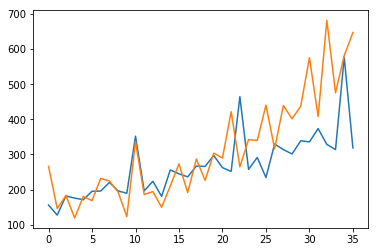

In [68]:
plt.plot(Forecast)
plt.plot(sales)
plt.show()

In [69]:
Forecast[-12:] #predicted forecast for year 3

array([[ 291.4318717 ],
       [ 234.27464541],
       [ 329.75840538],
       [ 313.826307  ],
       [ 301.27803869],
       [ 338.88841128],
       [ 335.78558302],
       [ 373.5673682 ],
       [ 328.64460754],
       [ 313.81267455],
       [ 576.86420151],
       [ 318.53183094]])

In [70]:
sales_test_y[:,np.newaxis] #Actual forecast for year 3

array([[ 339.7],
       [ 440.4],
       [ 315.9],
       [ 439.3],
       [ 401.3],
       [ 437.4],
       [ 575.5],
       [ 407.6],
       [ 682. ],
       [ 475.3],
       [ 581.3],
       [ 646.9]])

### Key Performance Indicators

#### Forecast Bias
A forecast bias occurs when there are consistent differences between actual outcomes and previously generated forecasts of those quantities; that is: forecasts may have a general tendency to be too high or too low. A normal property of a good forecast is that it is not biased

__Forecast Bias = 	( Actual - Forecast ) / Forecast __ 

performed over the entire test data.


In [71]:
A_F = np.subtract(sales_test_y[:,np.newaxis] , Forecast[-12:]) / np.sum(Forecast[-12:])
ForecastBias = np.sum(A_F)
ForecastBias

0.41559667686178647

#### Forecast Accuracy
The forecast accuracy is calculated as follows :

__Forecast Accuracy = 1 - Absolute Error/Actual __

over all the test data.

In [72]:
Abs_error = abs(np.subtract(sales_test_y[:,np.newaxis] , Forecast[-12:]))
ForecastAccuracy = 1 - np.sum(Abs_error)/np.sum(sales_test_y[:,np.newaxis])
ForecastAccuracy*100

70.158937318561172